# PANNA Tutorial

## Part 2 - Training and validation

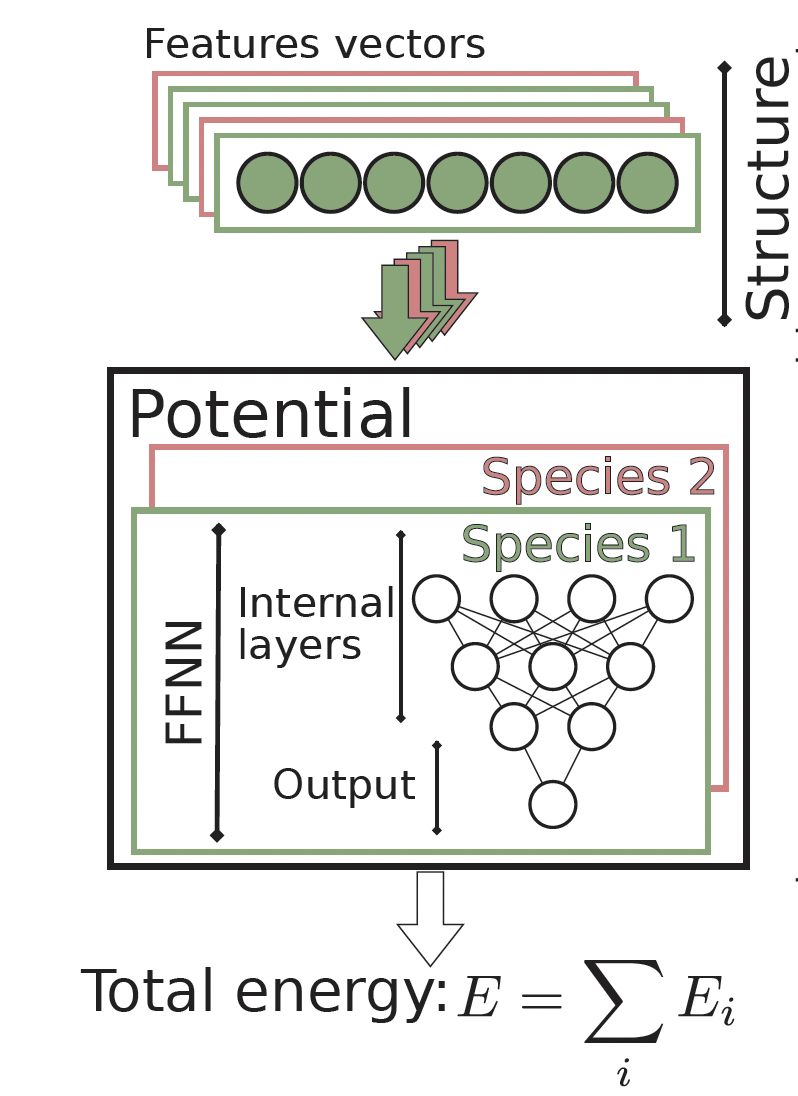
<div>
<p>


Once we have the data, we can start the supervised learning process with a neural network. PANNA is built on a TensorFlow engine for training and validating a neural network. In a standard use case, we interact with this engine only via PANNA python scripts and simple configuration files.

**This step has three, mostly concurrent parts:**

- Setting up a network architecture and hyperparameters
- Training and visualization of training
- Validation and testing


In this tutorial we will go through the simplest neural network type, i.e. a fully connected atomic network, where we have a fully-connected sub network for each atomic species, each sub network processes the G-vectors belonging to atoms of that species, and the total energy is calculated as a sum of all network outputs.
</p>
</div>

In this part of the tutorial tensorflow (version 2.xx) will be needed.
Check the next cell to setup your environment and uncomment the relative sections if you need to install packages. If you are using Google colab, you can mount your drive and you can use the version magic to specify the tensorflow version before importing it.
Plotting at the end of the tutorial will also require pandas and matplotlib.

In [1]:
import os

# Specify the absolute path to PANNA (or leave this relative path)
panna_dir = os.path.abspath('../..')

# In case you need to mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## ACTION NEEDED: Modify the directory so it points to 'panna-master' folder in your drive ##
# panna_dir =  '/content/drive/MyDrive/.../how2trainyournetwork_course/panna-master'
panna_dir = '/content/drive/MyDrive/SISSA/MLMS-SISSA/how2trainyournetwork_course/panna-master/'

# Cleaning up path for command line
panna_cmdir = panna_dir.replace(' ', '\ ')

# Check if PANNA is installed, otherwise install it
try:
  import panna
  print("PANNA is installed correctly.")
except ModuleNotFoundError:
  print("PANNA not found, attempting to install")
  !pip install {panna_cmdir}

# In case you have to install pandas
!pip install pandas

MessageError: Error: credential propagation was unsuccessful

### Part 2a - Setting up a network architecture

In PANNA, we set up a network architecture and hyperparameters in a configuration file, which is then used with the training script called ``train.py``.

The configuration file holds other important information as well, e.g. I/O details such as where to log the training information, how frequently data is recorded, and parallelization details.

Let's take a look at a minimal sample training configuration file:

In [37]:
!cat {panna_cmdir+'/doc/tutorial/input_files/mytrain.ini'}

[IO_INFORMATION]
data_dir = ./tutorial_data/train
train_dir = ./mytrain
log_frequency = 100
save_checkpoint_steps = 500

[DATA_INFORMATION]
atomic_sequence = H, C, O, N
output_offset = -13.62, -1029.41, -2041.84, -1484.87

[TRAINING_PARAMETERS]
batch_size = 20
learning_rate = 0.01
steps_per_epoch = 100
max_epochs = 100

[DEFAULT_NETWORK]
g_size = 384
architecture = 128:32:1
trainable = 1:1:1

[VALIDATION_OPTIONS]
data_dir = ./tutorial_data/validate

**Now we have defined a simple fully-connected network**, which is made up of 4 atomic networks (one for each species). By defeault each species network has the same architecture: 2 hidden layers of 128 and 32 nodes, 1 output node, and all nodes are trainable, i.e. no layer is frozen.

**We have also set some parameters for the trainig.** These sample parameters are going to result in a relatively short training (not very realistic for a production run!). At every step the learning is going to take place by using a loss/cost function using 20 configurations (as dictated by ``batch_size`` key). To determine how long the training will run, we define an "epoch" as a set of 100 steps, and require the code to perform 10 epochs of optimization, resulting in 1000 optimization steps (in theory an epoch is defined as the time to use each example in the training set once, but we can also choose it to be an arbitrary number).

**Note that we have not specified all the parameters we can here, we are relying on the defaults**. As you get more proficient with generation of NN potentials you can experiment with them all, e.g. different activation functions, training algorithms, fuctional forms for the loss function beyond the quadratic RMSE formula, regularization etc.

**PANNA is based on the TF engine.** So if a new activation function, or a fancy new training algorithm is available in TF, it is available in PANNA. Furthermore, we have also implemented several options that are only relevant for the atomistic simulation community, e.g. per-atom loss functions, Gaussian activation function to ensure smoothness of the final NN potential etc.

### Part 2b Training and visualization

In [ ]:
# Let us run a mock training case:
!cd {panna_cmdir+'/doc/tutorial/'}; python {panna_cmdir+'/src/panna/train.py'} --config ./input_files/mytrain.ini

This was a NN training for 1000 steps, 20 configurations in each batch. The total data we used was 900 configurations from H2O, NH3 and CH4 molecules, 300 configurations each. Configurations are taken from the ANI dataset and total energy calculations performed with Quantum Espresso, as we have done before in Part 1 of this tutorial.

We don't expect a reliable NN potential from this train, as for each species we are training a network of size ~(384 x 128) = 50k parameters, for 4 species this means a 200k parameter network, with considerably small amount of data. However, the training speed per batch does not change with the data size so even this small exercise is enough to show us how rapid the TF engine works, without even flexing with the parallelization algorithms available.

**Training speed is relevant for scientific applications**, because finding the right G-vector parameters, network architecture etc. can take many training trial and error iterations. Furthermore, this also allows us to build multiple networks for a single system and use committee-learning as a (very!) simplified approximation for error bar of our network predictions.

The training step has a few outputs to pay attention to, in the directory we specified as ``train_dir`` in the configuration file, for this example ``doc/tutorial/mytrain``:

As a default, the code writes to command line the error during training as the mean absolute error (MAE) per atom in the simulation. We can also access this data, computed once per epoch, in the file ``metrics.dat`` in the training directory.

In the subfolder ``_models`` in the same directory, we can find the neural network information as multiple 'checkpoints' i.e. snapshots of the network saved during training.

In [ ]:
!cat {panna_cmdir+'/doc/tutorial/mytrain/metrics.dat'}
!ls {panna_cmdir+'/doc/tutorial/mytrain/_models'}

One very useful TF tool for monitoring training is called tensorboard, which allows us to visualize the training process through multiple metrics.

The command in the next cell will start tensorboard pointing at your training directory.
If you're running on your local machine, this can then be opened in a browser by navigating to http://0.0.0.0:8080/.

Stop the execution of the cell once you're done exploring the board.

If you're running this in a remote environement such as Deepnote you might be able to access tensorboard by allowing incoming connection. E.g. for deepnote:
* Go to environment tab
* Allow incoming connections
* Copy the link you see there, which is where the visualizations will be served:

If you're running in Google colab, you should be able to use Tensorboard directly in the notebook by using the magics below instead of the command line.

In [ ]:
# !tensorboard --logdir={panna_cmdir+'/doc/tutorial/mytrain'} --host=0.0.0.0 --port=8080

# If you want to run in browser use the following magics instead
%load_ext tensorboard
%tensorboard --logdir {panna_cmdir+'/doc/tutorial/mytrain'}

Tensorboard allows us to visualize training as it goes on. It is useful to visualize multiple metrics at once and intervene as needed.



You can also plot the metrics yourself. An example is found below.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv(panna_cmdir+'/doc/tutorial/mytrain/metrics.dat', delim_whitespace=True)

<ipython-input-19-2339b5653e90>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(panna_cmdir+'/doc/tutorial/mytrain/metrics.dat', delim_whitespace=True)


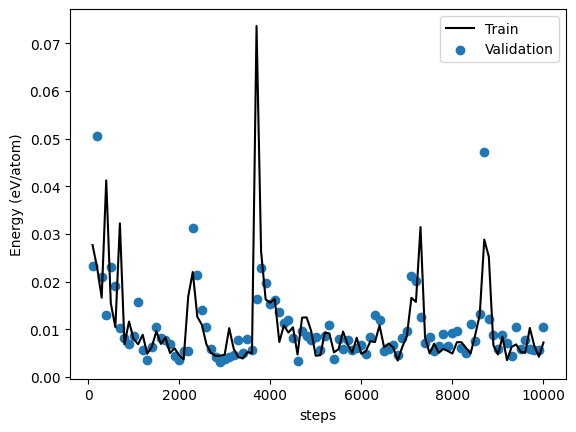

In [20]:
#Pandas have useful plotting tools but if you want to stick to matplotlib:
plt.plot(df['tot_st'], df['MAE/at'], color='k', label='Train')
plt.scatter(df['tot_st'], df['val_MAE/at'], label='Validation')
plt.ylabel('Energy (eV/atom)')
plt.xlabel('steps')
plt.legend()
plt.show()

### Part 2c Validation

We use the word "validation" here in its meaning in the machine learning community, i.e. **"does the model perform similarly on a dataset that was not used in the training?"**

Validation of the neural network can be done as the training continues by using the snapshots of the network that are stored during training, aka "checkpoints".  

Tensorflow also allows an automated validation embedded in the training, i.e. it stops the training at every X steps to evaluate the network on validation dataset. Here, to have more control, we will run validation manually instead.

The data we will use for validation purposes are placed in ``panna_data/tutorial/mytrain_val`` directory. Like the training step, the data are in tfr format, i.e. structures are converted to G-vectors and packaged.

In [21]:
!ls {panna_cmdir+'/doc/tutorial/tutorial_data/validate'}

train-2-10.tfrecord  train-5-10.tfrecord


The python script we will use for validation is called ``evaluate.py``. It takes a configuration file to identify important information, e.g. which neural network and data to use in validation and where to find them. Let's see a minimal sample configuration file:

In [22]:
!cat {panna_cmdir+'/doc/tutorial/input_files/myvalidation.ini'}

[IO_INFORMATION]
data_dir = ./tutorial_data/validate
train_ini = ./input_files/mytrain.ini
networks_dir = ./mytrain/_models
eval_dir = ./myvalidation

[VALIDATION_OPTIONS]
single_step = True 



The ``[IO_INFORMATION]`` section of the configuration file should point to where to find the stored networks ("checkpoints" saved while training) and ``[VALIDATION_OPTIONS]`` section gives us control about whether to evaluate every checkpoint, or just the last step of the training or a network that was produced at a particular training step we wish to examine.

In [23]:
!cd {panna_cmdir+'/doc/tutorial/'}; python {panna_cmdir+'/src/panna/evaluate.py'} --config ./input_files/myvalidation.ini

2025-01-15 13:21:52.918700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - 
    ____   _    _   _ _   _    _           
   |  _ \ / \  | \ | | \ | |  / \     
   | |_) / _ \ |  \| |  \| | / _ \     
   |  __/ ___ \| |\  | |\  |/ ___ \    
   |_| /_/   \_\_| \_|_| \_/_/   \_\ 

 Properties from Artificial Neural Network Architectures

INFO - reading ./input_files/myvalidation.ini
INFO - reading ./input_files/mytrain.ini
INFO - evaluating last checkpoint
INFO - Found a default network!
INFO - This network size will be used as default for all species unless specified otherwise
INFO - ----start evaluation----
INFO - validating network: 1/1, epoch: 100 step: 10000
180/180 [==============================] - 3s 6ms/step
INFO - eval time = 4.00 s
INFO - file names are not available
INFO - write time = 0.00 s


The validation ends rapidly, as we have only one network to validate on a small dataset. The results are in the directory we specified in the configuration file:

In [24]:
!ls {panna_cmdir+'/doc/tutorial/myvalidation'}

epoch_100_step_10000.dat


In [26]:
!head -5 {panna_cmdir+'/doc/tutorial/myvalidation/epoch_10_step_1000.dat'}

#filename n_atoms e_ref e_nn
N.A. 3 -2078.14306640625 -2078.13916015625
N.A. 4 -1537.5460205078125 -1537.5784912109375
N.A. 5 -1101.7099609375 -1101.6656494140625
N.A. 3 -2078.01318359375 -2078.037109375


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
dv = pd.read_csv(panna_dir+'/doc/tutorial/myvalidation/epoch_10_step_1000.dat', delim_whitespace=True)

<ipython-input-31-617d0f6b320c>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dv = pd.read_csv(panna_dir+'/doc/tutorial/myvalidation/epoch_100_step_10000.dat', delim_whitespace=True)


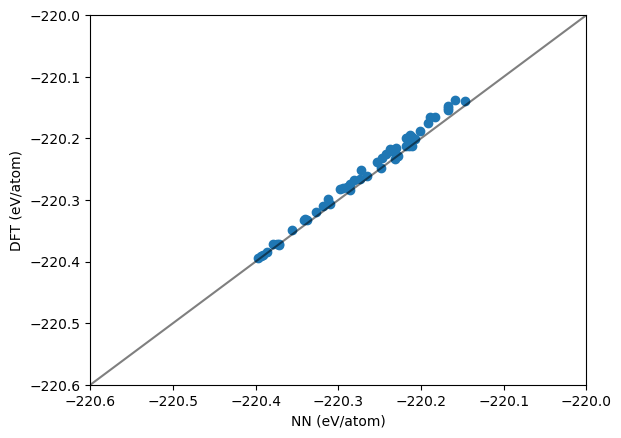

In [36]:
#Pandas have useful plotting tools but if you want to stick to matplotlib:
plt.scatter(dv['e_ref']/dv['n_atoms'], dv['e_nn']/dv['n_atoms'])
plt.ylabel('DFT (eV/atom)')
plt.xlabel('NN (eV/atom)')
lims = [min(-700, -200), max(-700, -200)]
plt.plot(lims, lims, color='k', alpha=0.5)
plt.xlim(-220.6,-220)
plt.ylim(-220.6,-220)
plt.show()

In [38]:
# Run this to cleanup the tutorial directory
# (do not remove these files if you want to follow part 3, converting the network to a lammps potential)
!cd {panna_cmdir+'/doc/tutorial'}; rm -rf mytrain mytrain_logs myvalidation tf.log